In [103]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
%matplotlib inline

In [15]:
file = open("song_tf_idf.pickle",'rb')
song_tf_idf = pickle.load(file)

file = open("wiki_tf_idf.pkl",'rb')
wiki_tf_idf = pickle.load(file)

In [16]:
from scipy.sparse.linalg import svds
# do SVD with a very large k (we usually use 100), just for the sake of getting many sorted singular values (aka importances)
u,s,v_trans = svds(song_tf_idf, k=100)

In [17]:
print(u.shape)
print(s.shape)
print(v_trans.shape)

(34554, 100)
(100,)
(100, 13784)


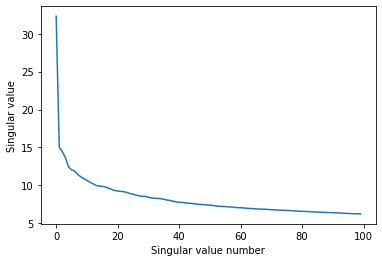

In [18]:
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [80]:
docs_compressed, s, words_compressed = svds(song_tf_idf, k=40)
words_compressed = words_compressed.transpose()

In [81]:
print(words_compressed.shape)
print(docs_compressed.shape)

(13784, 40)
(34554, 40)


In [82]:
file = open("word_to_index.pkl",'rb')
word_to_index = pickle.load(file)

file = open("index_to_word.pkl",'rb')
index_to_word = pickle.load(file)

In [83]:
from sklearn.preprocessing import normalize
words_compressed_normed = normalize(words_compressed, axis = 1)

In [84]:
# cosine similarity
def closest_words(word_in, words_representation_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]) for i in asort[1:]]

In [85]:
td_matrix_np = song_tf_idf.transpose().toarray()
td_matrix_np = normalize(td_matrix_np)

In [86]:
word = 'miami'
print("Using SVD:")
for w, sim in closest_words(word, words_compressed_normed):
    try:
        print("{}, {:.3f}".format(w, sim))
    except:
        print("word not found")
print()

Using SVD:
mcdonalds, 0.966
crew, 0.953
ransom, 0.950
nigga, 0.947
microwave, 0.947
rapper, 0.945
mickey, 0.944
wach, 0.942
embracing, 0.935
lyrical, 0.933



In [56]:
big_df = pd.read_csv('big_df.csv')

In [87]:
docs_compressed_normed = normalize(docs_compressed)

# this is basically the same cosine similarity code that we used before, just with some changes to
# the returned output format to let us print out the documents in a sensible way
def closest_projects(project_index_in, project_repr_in, k = 5):
    sims = project_repr_in.dot(project_repr_in[project_index_in,:])
    asort = np.argsort(-sims)[:k+1]
    return [(big_df['title'].iloc[i],sims[i]) for i in asort[1:]]

In [88]:
td_matrix_np = song_tf_idf.toarray()
td_matrix_np = normalize(td_matrix_np)

In [96]:
for i in range(9, 10):
    print("INPUT SONG: "+big_df['title'].iloc[i])
    print("CLOSEST SONGS w SVD:\n")
    for title, score in closest_projects(i, docs_compressed_normed):
        print("{}:{:.3f}".format(title, score))
    print()
    print("Using term-document matrix:")
    for title, score in closest_projects(i, td_matrix_np):
        print("{}:{:.3f}".format(title, score))
    print()
    print("--------------------------------------------------------\n")

INPUT SONG: Keys Open Doors
CLOSEST SONGS w SVD:

Get Low:0.813
I Told You So:0.796
Kung Fu:0.791
Concrete Jungle:0.783
Nobody Like You Lord:0.776

Using term-document matrix:
Cemetery Row:0.569
Break Your Frame:0.479
What It Is:0.466
Get Low:0.447
Bleed American:0.444

--------------------------------------------------------



In [104]:
from dataset import wiki_scraping
f = open('dataset/wiki_scraping/wiki_texts.json')
wiki_texts = json.load(f)
loc_to_index = {cty:i for i, cty in enumerate(wiki_texts.keys())}

In [109]:
def closest_songs_to_wiki(loc, k = 5):
    sims = docs_compressed_normed.dot(wiki_tf_idf[loc_to_index[loc], :])
    asort = np.argsort(-sims)[:k+1]
    return [(big_df['title'].iloc[i],sims[i]) for i in asort[1:]]

for k in wiki_texts.keys():
    print("INPUT WIKI: "+k)
    print("CLOSEST SONGS w SVD:\n")
    for title, score in closest_songs_to_wiki(k, k=5):
        print("{}:{:.3f}".format(title, score))
    print()
    print("Using term-document matrix:")
    for title, score in closest_projects(i, td_matrix_np):
        print("{}:{:.3f}".format(title, score))
    print()
    print("--------------------------------------------------------\n")

INPUT WIKI: New York City
CLOSEST SONGS w SVD:



ValueError: shapes (34554,40) and (13784,) not aligned: 40 (dim 1) != 13784 (dim 0)

In [90]:
# Once again, basically the same cosine similarity code, but mixing two different matrices
def closest_songs_to_word(word_in, k = 5):
    if word_in not in word_to_index: return "Not in vocab."
    sims = docs_compressed_normed.dot(words_compressed_normed[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(big_df['title'].iloc[i], big_df['artist'].iloc[i],sims[i]) for i in asort[1:]]

In [94]:
print("Top Matches\n")
for title, artist, sim in closest_songs_to_word("london"):
    print("{}, {}, {:.4f}".format(title, artist, sim))

Top Matches

A Little Too Not Over You, David Archuleta, 0.7674
Wishing Well, Jessica Andrews, 0.7673
The Christmas Song, Johnny Mathis, 0.7596
Runaway, Cascada, 0.7522
Phonebill Song, Hole, 0.7519


In [92]:
for i in range(20):
    print("Top words in dimension", i)
    dimension_col = words_compressed[:,i].squeeze()
    asort = np.argsort(-dimension_col)
    print([index_to_word[i] for i in asort[:10]])
    print()

Top words in dimension 0
['sai', 'things', 'hearse', 'tonic', 'lies', 'dictionary', 'gonna', 'litter', 'sheriff', 'wax']

Top words in dimension 1
['majority', 'nigh', 'hearse', 'iv', 'rig', 'believe', 'lonesome', 'things', 'icy', 'thing']

Top words in dimension 2
['televisions', 'dawns', 'liian', 'wax', 'nigh', 'combing', 'iv', 'gira', 'tonic', 'lies']

Top words in dimension 3
['televisions', 'nigh', 'hearse', 'gosto', 'litter', 'eyelids', 'nee', 'mammy', 'heap', 'feeds']

Top words in dimension 4
['gone', 'iv', 'jusquau', 'hearse', 'gira', 'dawns', 'feeds', 'sheriff', 'saxophone', 'lonesome']

Top words in dimension 5
['wax', 'gosto', 'oo', 'jusquau', 'eyelids', 'works', 'donner', 'hearse', 'tonic', 'dawns']

Top words in dimension 6
['oo', 'jusquau', 'televisions', 'gone', 'hearse', 'iv', 'hombres', 'lonesome', 'dictionary', 'wondrous']

Top words in dimension 7
['wax', 'gira', 'hearse', 'nee', 'tonic', 'sheriff', 'away', 'works', 'myth', 'therere']

Top words in dimension 8
['che